# 1. Introduction

The COVID-19 pandemic has generated vast amounts of data related to infections, healthcare demand, and vaccination coverage.  
For this lab, our objective is to **predict the number of daily new COVID-19 cases (`cases_new`) in Malaysia** using supervised learning methods.

We will evaluate three different models:  
1. **Linear Regression** – a simple baseline model that assumes linear relationships between features and cases.  
2. **Random Forest Regressor** – an ensemble method that handles non-linear interactions and provides feature importance.  
3. **Gradient Boosting Regressor** – a boosting method that iteratively improves performance by reducing errors step-by-step.

### Dataset
The data comes from the official **Ministry of Health Malaysia (MoH) COVID-19 datasets**, which include:  
- **cases_malaysia.csv** → provides daily new case counts.  
- **vax_malaysia.csv** → provides vaccination progress (partial, full, booster doses).  
- Dataset sources:
    - https://github.com/MoH-Malaysia/covid19-public/tree/main/epidemic
    - https://github.com/CITF-Malaysia/citf-public

For this study, we merge these datasets and engineer features such as **lagged cases** (previous day’s cases), along with vaccination-related predictors.

### Evaluation Metrics
To compare model performance, we will measure:  
- **MAE (Mean Absolute Error)** → average prediction error.  
- **RMSE (Root Mean Squared Error)** → penalises larger errors more heavily.  
- **R² (Coefficient of Determination)** → measures how well the model explains variance in cases.  
- **Training Time** → computational efficiency.  

### Workflow
1. Data loading and cleaning.  
2. Feature engineering (vaccination features + lagged cases).  
3. Train/validation/test split (70/15/15).  
4. Model training (Linear Regression, Random Forest, Gradient Boosting).  
5. Evaluation on training and validation sets.  
6. Final test set evaluation of the best model.  
7. Visualization and interpretation of results.  

By the end of this lab, we will identify which supervised learning method is most effective for predicting COVID-19 daily cases in Malaysia and analyze the trade-offs between **accuracy, training speed, and interpretability**.



In [12]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 2. Data Preparation
To prepare the dataset for supervised learning, we perform the following steps:

### 2.1 Load and Inspect Data
We use two key datasets:
- **cases_malaysia.csv** → contains daily new COVID-19 cases.  
- **vax_malaysia.csv** → contains vaccination data (partial, full, booster doses).

In [13]:
# Load cases and vaccination datasets
cases = pd.read_csv("cases_malaysia.csv")
vax = pd.read_csv("vax_malaysia.csv")

### 2.2 Data Cleaning
- Remove any completely empty columns.  
- Convert the `date` column to datetime format.  
- Ensure datasets are aligned properly.

In [14]:
# Remove null columns
cases = cases.dropna(axis=1, how="all")
vax = vax.dropna(axis=1, how="all")

# Ensure date is datetime
cases["date"] = pd.to_datetime(cases["date"])
vax["date"] = pd.to_datetime(vax["date"])

### 2.3 Merge Datasets & Select Date Range
We merge the cases and vaccination datasets on the `date` field.

In [15]:
# Merge on date
df = pd.merge(cases, vax, on="date", how="inner")

# Select date range
start_date = pd.to_datetime("2021-03-01")
end_date = start_date + pd.DateOffset(months=6)

mask = (df["date"] >= start_date) & (df["date"] < end_date)
df = df.loc[mask]

# Preview merged dataset
df

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,sinopharm2,sinopharm3,sinopharm4,cansino,cansino3,cansino4,pending1,pending2,pending3,pending4
5,2021-03-01,1828,7,2486,25538,962,1828,0,0,0,...,0,0,0,0,0,0,6,0,0,0
6,2021-03-02,1555,3,2528,24559,604,1555,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2021-03-03,1745,2,2276,24021,867,1744,1,0,0,...,0,0,0,0,0,0,5,0,0,0
8,2021-03-04,2063,9,2922,23157,897,2062,1,0,0,...,0,0,0,0,0,0,4,3,0,0
9,2021-03-05,2154,5,3275,22030,1021,2151,3,0,0,...,0,0,0,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2021-08-27,22070,15,21877,265699,2126,10533,6492,5045,0,...,0,0,0,1392,0,0,8,34,0,0
185,2021-08-28,22597,12,19492,268552,2551,10424,6856,5317,0,...,0,0,0,6986,0,0,4,39,0,0
186,2021-08-29,20579,7,20845,268001,2595,10009,5648,4922,0,...,0,0,0,7745,0,0,26,16,0,0
187,2021-08-30,19268,16,21257,265718,2097,9325,5289,4654,0,...,0,0,0,4263,0,0,32,15,0,0


### 2.4 Feature Engineering
To improve predictions, we construct features:
- **daily_partial, daily_full, daily_booster** (vaccination progress).  
- **cases_lag1** = yesterday’s cases (to capture autocorrelation in time-series).  

In [16]:
# Target variable
y = df["cases_new"]

# Basic feature set: vaccination data
X = df[["daily_partial", "daily_full", "daily_booster"]].copy()

# Add lagged feature: yesterday's cases (shift by 1 day)
df["cases_lag1"] = df["cases_new"].shift(1)
X["cases_lag1"] = df["cases_lag1"]

# Drop rows with NaN from lagging
X = X.dropna()
y = y.loc[X.index]


### 2.5 Train / Validation / Test Split
Since this is **time-series data**, we split without shuffling:
- **70% Training set** → model fitting.  
- **15% Validation set** → model selection.  
- **15% Test set** → final unbiased evaluation

In [17]:
# Determine sizes
train_size = int(0.7 * len(X))
val_size   = int(0.15 * len(X))

# Split datasets (no shuffle for time-series)
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val   = X.iloc[train_size:train_size+val_size]
y_val   = y.iloc[train_size:train_size+val_size]

X_test  = X.iloc[train_size+val_size:]
y_test  = y.iloc[train_size+val_size:]

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 128
Validation samples: 27
Testing samples: 28


# 3. Shared Utilities

To streamline our workflow, we define reusable helper functions for:

### 3.1 Model Evaluation
- Trains the model on the training set.  
- Records **training time**.  
- Computes metrics (MAE, RMSE, R²) for **training** and **validation** sets.  
- Prints a summary.  
- Returns results in a dictionary for later comparison.

In [18]:
import time

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name="Model"):
    # Measure training time
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    train_time = end - start
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred   = model.predict(X_val)
    
    # Training metrics
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    
    # Validation metrics
    mae_val = mean_absolute_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val = r2_score(y_val, y_val_pred)
    
    # Print summary
    print(f"{model_name} Performance:")
    print(f"Training Time: {train_time:.4f} seconds")
    print(f"Train → MAE: {mae_train:.2f}, RMSE: {rmse_train:.2f}, R²: {r2_train:.2f}")
    print(f"Valid → MAE: {mae_val:.2f}, RMSE: {rmse_val:.2f}, R²: {r2_val:.2f}")
    print("-"*50)
    
    return {
        "Model": model_name,
        "Train_Time": train_time,
        "Train_MAE": mae_train, "Train_RMSE": rmse_train, "Train_R2": r2_train,
        "Val_MAE": mae_val, "Val_RMSE": rmse_val, "Val_R2": r2_val
    }

### 3.2 Final Test Evaluation
- After model selection, we use the **test set** for unbiased evaluation.  
- Reports metrics (MAE, RMSE, R²).

In [19]:
def final_test_evaluation(model, X_test, y_test, model_name="Model"):
    y_test_pred = model.predict(X_test)
    
    # Test metrics
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    
    # Print summary
    print(f"Final Test Performance for {model_name}:")
    print(f"MAE  : {mae_test:.2f}")
    print(f"RMSE : {rmse_test:.2f}")
    print(f"R²   : {r2_test:.2f}")
    print("="*50)
    
    return {"Model": model_name, "Test_MAE": mae_test, "Test_RMSE": rmse_test, "Test_R2": r2_test}

### 3.3 Visualization
We add plotting helpers:
- **Predicted vs. Actual Plot** → checks accuracy visually.  
- **Residual Plot** → shows if the model under/overfits. 

In [20]:
def plot_predicted_vs_actual(y_true, y_pred, model_name="Model"):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual Cases")
    plt.ylabel("Predicted Cases")
    plt.title(f"{model_name}: Predicted vs Actual")
    plt.show()

def plot_residuals(y_true, y_pred, model_name="Model"):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted Cases")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"{model_name}: Residual Plot")
    plt.show()

# 4. Models

In this section, each team member implements their assigned supervised learning method.  
Each model is trained on the same dataset (features + lagged cases) for a fair comparison.  
We evaluate performance on both training and validation sets, visualize results, and provide short analyses.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import learning_curve, validation_curve

### 4.1 Linear Regression

Linear Regression is a simple baseline model that assumes a linear relationship between predictors (vaccinations, lagged cases) and the target (`cases_new`).  
It is fast to train, interpretable, but may underfit complex relationships.


### Linear Regression ###
Linear Regression Performance:
Training Time: 0.0964 seconds
Train → MAE: 380.53, RMSE: 494.98, R²: 0.95
Valid → MAE: 953.38, RMSE: 1184.42, R²: 0.85
--------------------------------------------------


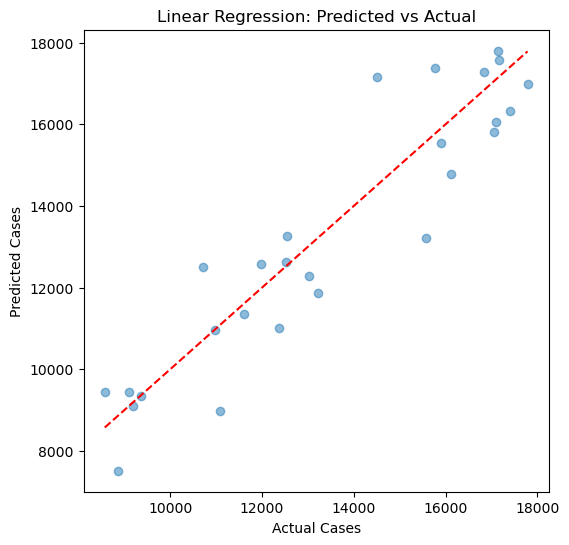

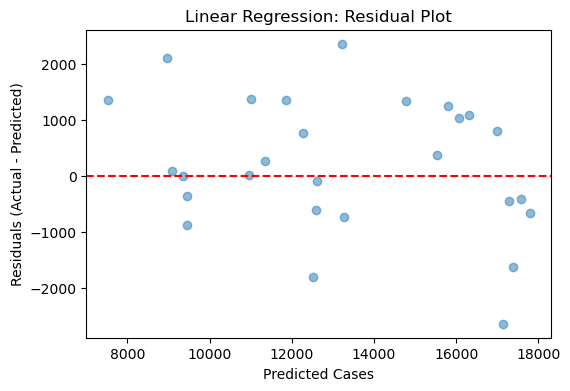

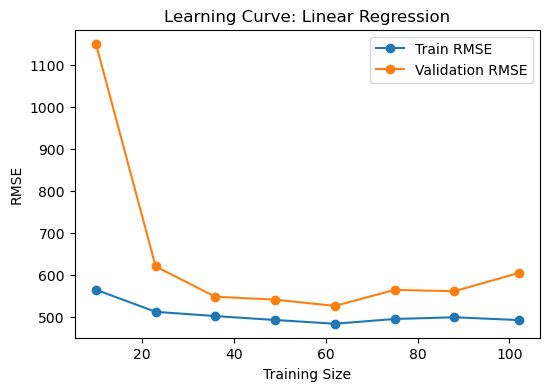

In [22]:
print("### Linear Regression ###")
lin_reg = LinearRegression()
results_lr = evaluate_model(lin_reg, X_train, y_train, X_val, y_val, "Linear Regression")

# Predictions
y_val_pred_lr = lin_reg.predict(X_val)
plot_predicted_vs_actual(y_val, y_val_pred_lr, "Linear Regression")
plot_residuals(y_val, y_val_pred_lr, "Linear Regression")

# Learning Curve (Under/Overfitting check)
train_sizes, train_scores, val_scores = learning_curve(
    lin_reg, X_train, y_train, cv=5, scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 8), shuffle=True, random_state=42
)
train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse   = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_rmse, "o-", label="Train RMSE")
plt.plot(train_sizes, val_rmse, "o-", label="Validation RMSE")
plt.title("Learning Curve: Linear Regression")
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### 4.2 Random Forest Regressor

Random Forest is an ensemble of decision trees. It captures non-linear relationships, handles feature importance, and usually performs well. However, it can be computationally expensive and prone to overfitting if not tuned carefully.


### Random Forest ###
Random Forest Performance:
Training Time: 31.2297 seconds
Train → MAE: 229.75, RMSE: 288.21, R²: 0.98
Valid → MAE: 5668.24, RMSE: 6424.44, R²: -3.45
--------------------------------------------------


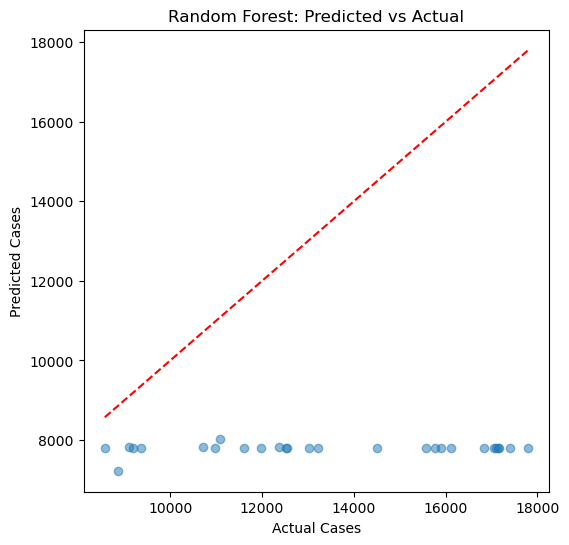

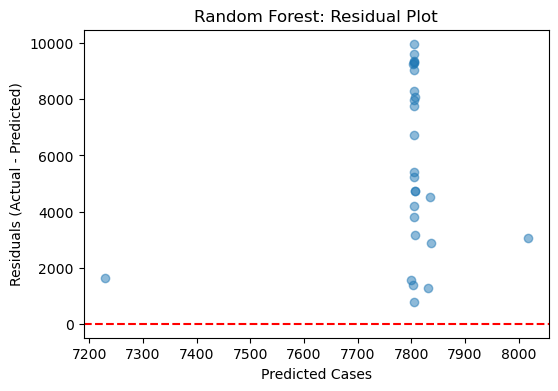

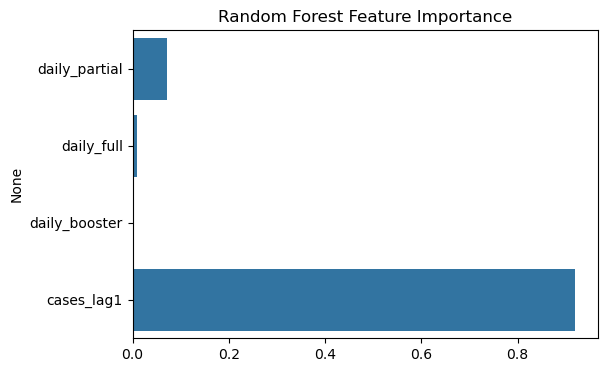

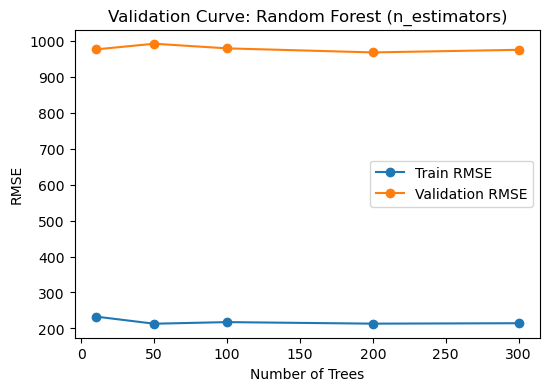

In [34]:
print("### Random Forest ###")
rf = RandomForestRegressor(n_estimators=10000, max_depth=5, random_state=42)
results_rf = evaluate_model(rf, X_train, y_train, X_val, y_val, "Random Forest")

# Predictions
y_val_pred_rf = rf.predict(X_val)
plot_predicted_vs_actual(y_val, y_val_pred_rf, "Random Forest")
plot_residuals(y_val, y_val_pred_rf, "Random Forest")

# Feature Importance
importances = rf.feature_importances_
features = X_train.columns
plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=features, orient="h")
plt.title("Random Forest Feature Importance")
plt.show()

# Validation Curve (Under/Overfitting check: vary n_estimators)
param_range = [10, 50, 100, 200, 300]
train_scores, val_scores = validation_curve(
    RandomForestRegressor(max_depth=10, random_state=42),
    X_train, y_train, param_name="n_estimators", param_range=param_range,
    cv=3, scoring="neg_mean_squared_error"
)
train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse   = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(6,4))
plt.plot(param_range, train_rmse, "o-", label="Train RMSE")
plt.plot(param_range, val_rmse, "o-", label="Validation RMSE")
plt.title("Validation Curve: Random Forest (n_estimators)")
plt.xlabel("Number of Trees")
plt.ylabel("RMSE")
plt.legend()
plt.show()

### 4.3 Gradient Boosting Regressor

Gradient Boosting builds an ensemble of weak learners (shallow trees), sequentially improving predictions by focusing on errors. It often provides strong accuracy, but can be slower to train and harder to tune than Random Forest.

### Gradient Boosting ###
Gradient Boosting Performance:
Training Time: 0.1398 seconds
Train → MAE: 60.20, RMSE: 75.77, R²: 1.00
Valid → MAE: 6232.39, RMSE: 6947.31, R²: -4.20
--------------------------------------------------


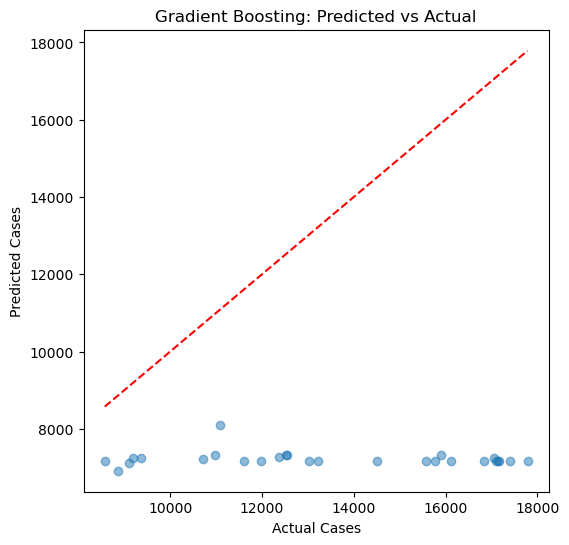

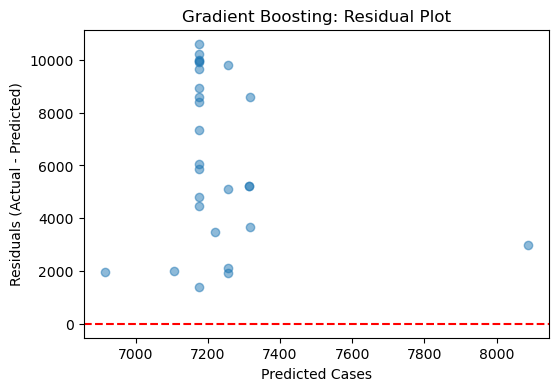

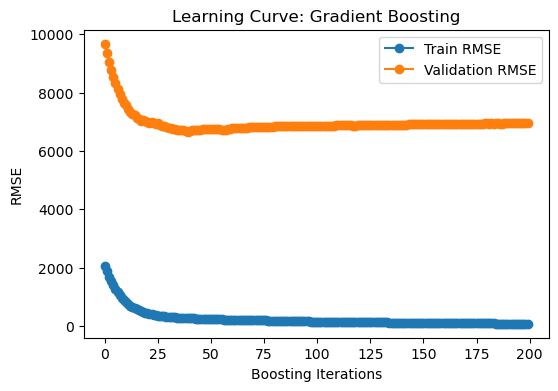

In [24]:
print("### Gradient Boosting ###")
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
results_gb = evaluate_model(gb, X_train, y_train, X_val, y_val, "Gradient Boosting")

# Predictions
y_val_pred_gb = gb.predict(X_val)
plot_predicted_vs_actual(y_val, y_val_pred_gb, "Gradient Boosting")
plot_residuals(y_val, y_val_pred_gb, "Gradient Boosting")

# Learning Curve (Under/Overfitting check: staged_predict)
train_errors, val_errors = [], []
for y_train_pred, y_val_pred in zip(gb.staged_predict(X_train), gb.staged_predict(X_val)):
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse   = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

plt.figure(figsize=(6,4))
plt.plot(train_errors, "o-", label="Train RMSE")
plt.plot(val_errors, "o-", label="Validation RMSE")
plt.title("Learning Curve: Gradient Boosting")
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE")
plt.legend()
plt.show()

# 5. Results & Comparison

Now that each model has been trained and validated, we bring together their metrics for direct comparison. We examine both **performance metrics** (MAE, RMSE, R²) and **training time**, then visualize differences. Finally, we run a final evaluation on the **test dataset** to check generalization.

### 5.1 Comparison Table

In [25]:
# Combine validation results into one DataFrame
results_df = pd.DataFrame([results_lr, results_rf, results_gb])
results_df


,Model,Train_Time,Train_MAE,Train_RMSE,Train_R2,Val_MAE,Val_RMSE,Val_R2
0,Linear Regression,0.096376,380.526884,494.978510,0.953007,953.381220,1184.418264,0.848725
1,Random Forest,0.161897,155.147211,199.731799,0.992348,5720.459259,6473.893070,-3.519469
2,Gradient Boosting,0.139816,60.204315,75.769024,0.998899,6232.393127,6947.314398,-4.204635


### 5.2 Performance Comparison Plots

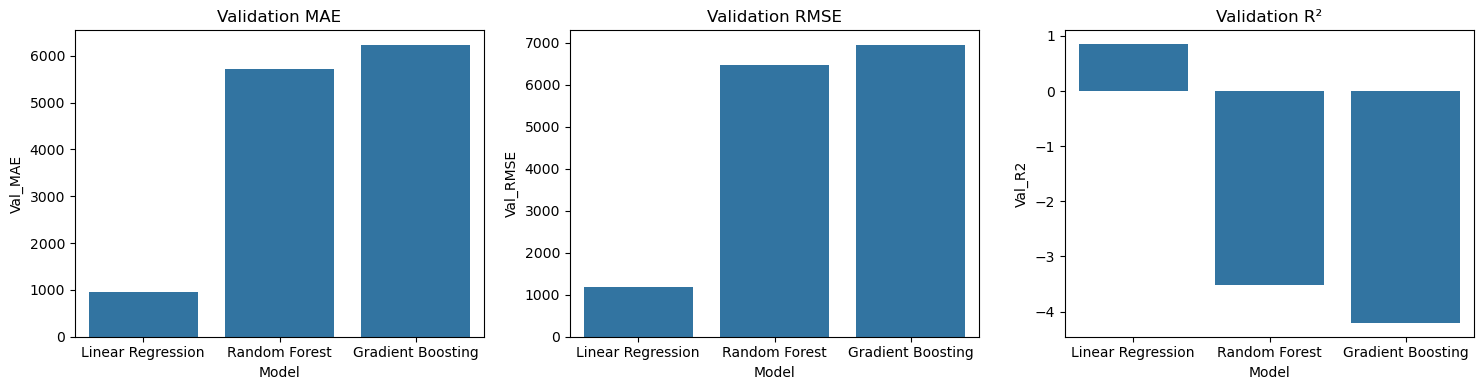

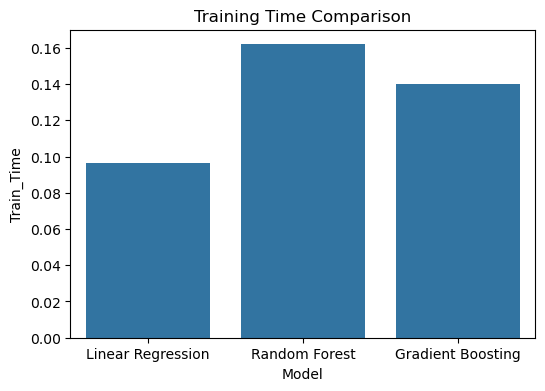

In [26]:
# Plot comparison of metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.barplot(data=results_df, x="Model", y="Val_MAE", ax=axes[0])
axes[0].set_title("Validation MAE")

sns.barplot(data=results_df, x="Model", y="Val_RMSE", ax=axes[1])
axes[1].set_title("Validation RMSE")

sns.barplot(data=results_df, x="Model", y="Val_R2", ax=axes[2])
axes[2].set_title("Validation R²")

plt.tight_layout()
plt.show()

# Training time comparison
plt.figure(figsize=(6,4))
sns.barplot(data=results_df, x="Model", y="Train_Time")
plt.title("Training Time Comparison")
plt.show()


### 5.3 Final Test Evaluation

In [27]:
# Run final evaluation on test set for all models
final_lr = final_test_evaluation(lin_reg, X_test, y_test, "Linear Regression")
final_rf = final_test_evaluation(rf, X_test, y_test, "Random Forest")
final_gb = final_test_evaluation(gb, X_test, y_test, "Gradient Boosting")

# Combine test results
test_results_df = pd.DataFrame([final_lr, final_rf, final_gb])
test_results_df

Final Test Performance for Linear Regression:
MAE  : 1345.38
RMSE : 1581.01
R²   : 0.09
Final Test Performance for Random Forest:
MAE  : 13064.27
RMSE : 13169.74
R²   : -61.84
Final Test Performance for Gradient Boosting:
MAE  : 13619.02
RMSE : 13720.88
R²   : -67.21


,Model,Test_MAE,Test_RMSE,Test_R2
0,Linear Regression,1345.381162,1581.006749,0.094414
1,Random Forest,13064.271071,13169.735365,-61.837107
2,Gradient Boosting,13619.024469,13720.882792,-67.206568


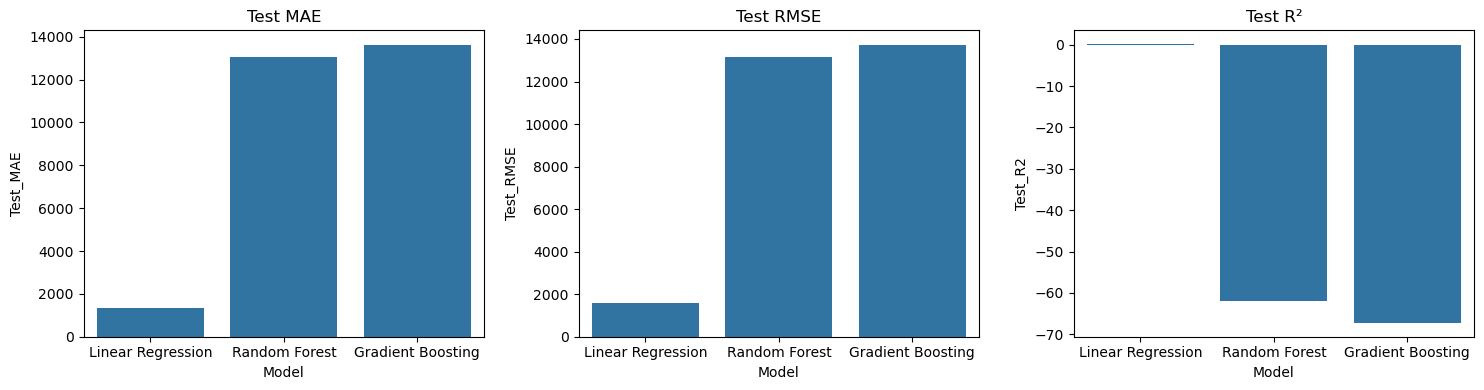

In [28]:
# Combine into DataFrame
test_results_df = pd.DataFrame([final_lr, final_rf, final_gb])

# Plot comparison of test metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.barplot(data=test_results_df, x="Model", y="Test_MAE", ax=axes[0])
axes[0].set_title("Test MAE")

sns.barplot(data=test_results_df, x="Model", y="Test_RMSE", ax=axes[1])
axes[1].set_title("Test RMSE")

sns.barplot(data=test_results_df, x="Model", y="Test_R2", ax=axes[2])
axes[2].set_title("Test R²")

plt.tight_layout()
plt.show()

### 5.4 Key observations

### Summary of Results
- **Linear Regression**: 
  
- **Random Forest**: 
  

- **Gradient Boosting**: 
   

### Overall Best Model



# 6. Conclusion & Next Steps